In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import math

base_path = "/content/drive/MyDrive/CIC-IDS/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/MachineLearningCSV/MachineLearningCVE"

csv_files = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

dfs = [pd.read_csv(os.path.join(base_path, f)) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)
data.columns = data.columns.str.strip()

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

def map_label(l):
    l = str(l).strip()
    if l == "BENIGN": return "Benign"
    if "DoS" in l or "DDoS" in l: return "DoS/DDoS"
    if "PortScan" in l: return "PortScan"
    if "Patator" in l or "Brute Force" in l: return "Brute Force"
    if "Web Attack" in l: return "Web Attacks"
    return None

data["Class"] = data["Label"].apply(map_label)
data = data[data["Class"].notna()]

print("Labels mapped:", data["Class"].value_counts())


MAX_SAMPLES_PER_CLASS = 60000

sampled_data = []

for cls in data["Class"].unique():
    df_cls = data[data["Class"] == cls]

    if len(df_cls) > MAX_SAMPLES_PER_CLASS:
        df_cls = df_cls.sample(MAX_SAMPLES_PER_CLASS, random_state=42)

    sampled_data.append(df_cls)

data = pd.concat(sampled_data, ignore_index=True)

print("After balanced sampling:", data.shape)
print(data["Class"].value_counts())

cols_to_drop = ["Label", "Timestamp", "Flow ID", "Source IP",
                "Destination IP", "Source Port", "Destination Port", "Protocol"]

for c in cols_to_drop:
    if c in data.columns:
        data = data.drop(columns=[c])

X = data.select_dtypes(include=["float64", "int64"])
y = data["Class"]

X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Standardized shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Labels mapped: Class
Benign         2271320
DoS/DDoS        379737
PortScan        158804
Brute Force      15339
Web Attacks        673
Name: count, dtype: int64
After balanced sampling: (196012, 80)
Class
Benign         60000
DoS/DDoS       60000
PortScan       60000
Brute Force    15339
Web Attacks      673
Name: count, dtype: int64
Standardized shapes: (137208, 77) (29402, 77) (29402, 77)


In [ ]:
from sklearn.cluster import Birch
from sklearn.preprocessing import OneHotEncoder
import numpy as np

n_clusters = 20
birch = Birch(n_clusters=n_clusters)
birch.fit(X_train_s)

train_clusters = birch.labels_
val_clusters   = birch.predict(X_val_s)
test_clusters  = birch.predict(X_test_s)

print("Cluster label sample:", np.unique(train_clusters))

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_cluster_oh = ohe.fit_transform(train_clusters.reshape(-1, 1))
val_cluster_oh   = ohe.transform(val_clusters.reshape(-1, 1))
test_cluster_oh  = ohe.transform(test_clusters.reshape(-1, 1))

print("One-hot shape (train):", train_cluster_oh.shape)

X_train_birch = np.concatenate([X_train_s, train_cluster_oh], axis=1)
X_val_birch   = np.concatenate([X_val_s,   val_cluster_oh],   axis=1)
X_test_birch  = np.concatenate([X_test_s,  test_cluster_oh],  axis=1)

input_dim_birch = X_train_birch.shape[1]
num_classes     = len(le.classes_)

print("Birch hybrid shapes:")
print("Train:", X_train_birch.shape)
print("Val:  ", X_val_birch.shape)
print("Test: ", X_test_birch.shape)
print("Input dim birch:", input_dim_birch)


Cluster label sample: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
One-hot shape (train): (137208, 20)
Birch hybrid shapes:
Train: (137208, 97)
Val:   (29402, 97)
Test:  (29402, 97)
Input dim birch: 97


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import math

def build_cldnn(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_1d_cnn(input_dim, num_classes):
    m = models.Sequential([
        layers.Reshape((input_dim, 1)),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cnn(input_dim, num_classes):
    side = int(math.ceil(math.sqrt(input_dim)))
    pad = side*side - input_dim
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Lambda(lambda x: tf.pad(x, [[0,0],[0,pad]])),
        layers.Reshape((side, side, 1)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cnn_lstm(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Reshape((input_dim, 1)),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m


In [ ]:
def run(model, name, X_tr, X_v, X_te):
    print(f"\n===== {name} =====")
    history = model.fit(
        X_tr, y_train,
        validation_data=(X_v, y_val),
        epochs=5,
        batch_size=64,
        verbose=1
    )

    val_acc  = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    print(f"Validation Accuracy: {val_acc:.6f}")
    print(f"Validation Loss:     {val_loss:.6f}")

    loss, acc = model.evaluate(X_te, y_test, verbose=0)
    print(f"Test Accuracy:       {acc:.6f}")
    print(f"Test Loss:           {loss:.6f}")

    preds = model.predict(X_te).argmax(axis=1)

    print(classification_report(
        y_test,
        preds,
        target_names=le.classes_,
        digits=6
    ))
    print("Confusion:\n", confusion_matrix(y_test, preds))

    return history, preds


In [ ]:
cldnn_birch = build_cldnn(input_dim_birch, num_classes)
hist_birch_cldnn, preds_birch_cldnn = run(
    cldnn_birch, "Birch + ClDNN",
    X_train_birch, X_val_birch, X_test_birch
)

cnn1d_birch = build_1d_cnn(input_dim_birch, num_classes)
hist_birch_1dcnn, preds_birch_1dcnn = run(
    cnn1d_birch, "Birch + 1D-CNN",
    X_train_birch, X_val_birch, X_test_birch
)

cnn_birch = build_cnn(input_dim_birch, num_classes)
hist_birch_cnn, preds_birch_cnn = run(
    cnn_birch, "Birch + CNN",
    X_train_birch, X_val_birch, X_test_birch
)

cnnlstm_birch = build_cnn_lstm(input_dim_birch, num_classes)
hist_birch_cnnlstm, preds_birch_cnnlstm = run(
    cnnlstm_birch, "Birch + CNN-LSTM",
    X_train_birch, X_val_birch, X_test_birch
)



===== Birch + ClDNN =====
Epoch 1/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9066 - loss: 0.2474 - val_accuracy: 0.9588 - val_loss: 0.1161
Epoch 2/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9536 - loss: 0.1225 - val_accuracy: 0.9662 - val_loss: 0.0998
Epoch 3/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9592 - loss: 0.1097 - val_accuracy: 0.9564 - val_loss: 0.1177
Epoch 4/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9634 - loss: 0.1001 - val_accuracy: 0.9685 - val_loss: 0.0892
Epoch 5/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9636 - loss: 0.0996 - val_accuracy: 0.9662 - val_loss: 0.0981
Validation Accuracy: 0.966159
Validation Loss:     0.098137
Test Accuracy:       0.966839
Test Loss:           0.096519
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign   0.990975  0.915000  0.951473      9000
 Brute Force   0.842610  0.993481  0.911847      2301
    DoS/DDoS   0.964324  0.991111  0.977534      9000
    PortScan   0.984336  0.998444  0.991340      9000
 Web Attacks   0.000000  0.000000  0.000000       101

    accuracy                       0.966839     29402
   macro avg   0.756449  0.779607  0.766439     29402
weighted avg   0.965770  0.966839  0.965284     29402

Confusion:
 [[8235  314  310  141    0]
 [  10 2286    3    2    0]
 [  63   17 8920    0    0]
 [   0    2   12 8986    0]
 [   2   94    5    0    0]]

===== Birch + 1D-CNN =====
Epoch 1/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.8650 - loss: 0.3832 - val_accuracy: 0.9556 - val_loss: 0.1452
Epoch 2/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9492 - loss: 0.1440 - val_accuracy: 0.9445 - val_loss: 0.1319
Epoch 3/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9557

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


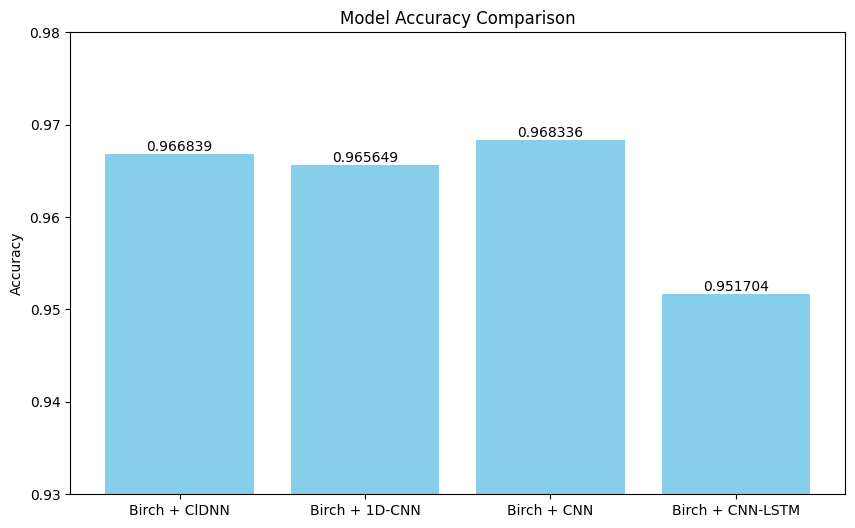

In [ ]:
import matplotlib.pyplot as plt

models = ["Birch + ClDNN", "Birch + 1D-CNN", "Birch + CNN", "Birch + CNN-LSTM"]
accuracies = [0.966839, 0.965649, 0.968336, 0.951704]

plt.figure(figsize=(10,6))
plt.bar(models, accuracies, color='skyblue')
plt.ylim(0.930, 0.980)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.6f}", ha='center', va='bottom')

plt.show()